# 线性回归的从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集
根据带有噪声的线性模型构造一个人造数据集，共包含1000个样本，每个样本包含从正态分布中采样的2个特征，$\mathbf{X} \in \mathbb{R}^{1000 \times 2}$。

使用线性模型参数$\mathbf{w} = [2, -3.4] ^ \top$、$b = 4.2$和噪声项$\epsilon$生成数据集和标签：
$$\mathbf{y} = \mathbf{X}\mathbf{w} + b + \epsilon$$

In [2]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

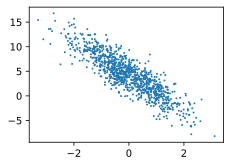

In [5]:
# features中第二个特征和标签的散点图
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

## 读取数据集
模型在训练时，需要读取一个批量的样本，因此需要定义支持打乱数据集并且返回批量数据的函数。

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5311,  0.2062],
        [-0.5571, -1.8728],
        [-0.0676, -1.0623],
        [-1.4562,  0.6000],
        [-0.3495, -0.2772],
        [-0.0153, -0.8776],
        [-0.0616, -0.5181],
        [ 0.3339,  0.6945],
        [ 1.4757, -0.2375],
        [-0.2449, -0.7621]]) 
 tensor([[ 2.4372],
        [ 9.4563],
        [ 7.6821],
        [-0.7573],
        [ 4.4535],
        [ 7.1483],
        [ 5.8309],
        [ 2.5147],
        [ 7.9397],
        [ 6.3116]])


## 初始化模型参数

In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
# w = torch.zeros((2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [9]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 定义损失函数

In [10]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

In [11]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

概括一下，我们将执行以下循环：

* 初始化参数
* 重复，直到完成
    * 计算梯度 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [13]:
for epoch in range(0, num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()): f}')

epoch 1, loss  0.031195
epoch 2, loss  0.000110
epoch 3, loss  0.000049


In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0006, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([-8.4877e-05], grad_fn=<RsubBackward1>)


## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设你是 [乔治·西蒙·欧姆](https://en.wikipedia.org/wiki/Georg_Ohm) ，试图为电压和电流的关系建立一个模型。你能使用自动微分来学习模型的参数吗?
1. 您能基于 [普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law) 使用光谱能量密度来确定物体的温度吗？
1. 如果你想计算二阶导数可能会遇到什么问题？你会如何解决这些问题？
1. 为什么在 `squared_loss` 函数中需要使用 `reshape` 函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？